In [1]:
import numpy as np
import pandas as pd
import spei as si 
import geopandas as gpd
from shapely.geometry import Point
import fiona 
from pyproj import CRS
import scipy.stats as scs

### Import boundaries for spatial distribution

In [2]:
# Read the shapefile
shapefile_path = '//gmvstorage.gmv.es/storage/anin/South_African_secondaryCatchments/Secondary Catchment.shp'
areas = gpd.read_file(shapefile_path)

# Field in the shapefile table of attributes to be used for the averaging of the SGI in this case  "SECONDARY" for secondary catchments
grouping_field = 'SECONDARY' 

#### Parametrization to be adjusted

In [3]:
# Define the CRS in which we're going to be working 
mycrs = 'EPSG:4326'
# General output path:
path_out = "//gmvstorage.gmv.es/storage/anin/Streamflow/outputs"

# Output directory: In this case  Secondary_catchments 
dir_out = "SSFI"

### Import streamflow data

In [4]:
streamflow_data = "//gmvstorage.gmv.es/storage/anin/Streamflow/processed_data/clean_streamflow.xlsx"
df_streamflow = pd.read_excel(streamflow_data, index_col=0)

metadata = "//gmvstorage.gmv.es/storage/anin/Streamflow/processed_data/clean_metadata.xlsx"
df_metadata = pd.read_excel(metadata, index_col=0)

# Simplify the metadata to just keep the station names and geographical coordinates

df_metadata = df_metadata.set_index('STATION')[['LONGITUDE', 'LATITUDE']]
df_metadata

,LONGITUDE,LATITUDE
STATION,,
A2H006,28.316500,-25.380220
A2H012,27.909830,-25.810560
A2H013,27.761170,-25.777030
A2H014,27.985390,-25.798280
A2H021,27.628580,-25.128560
...,...,...
X3H002,30.778333,-25.088000
X3H003,30.814444,-24.993278
X3H004,31.130528,-25.076194


### Compute the SSFI for all the stations

In [5]:
# Import the modified sgi function which includes scaling 
from ssfi_tools import compute_ssfi

In [6]:
# Define index scale factor and distribution
scale = 3

# Create a new DataFrame to store the SGI values
df_ssfi = pd.DataFrame()

# Apply the SGI function to each column of the DataFrame

for column in df_streamflow.columns:
    df_ssfi[column] = compute_ssfi(df_streamflow[column],scale)

# Reset the index & Transpose the DataFrame
dates = df_ssfi.index.to_pydatetime()
df_ssfi = df_ssfi.reset_index(drop = True)
df_ssfi = df_ssfi.T

C:\Users\ecig\AppData\Local\Temp\ipykernel_21828\1832167417.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ssfi[column] = compute_ssfi(df_streamflow[column],scale)
C:\Users\ecig\AppData\Local\Temp\ipykernel_21828\1832167417.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ssfi[column] = compute_ssfi(df_streamflow[column],scale)
C:\Users\ecig\AppData\Local\Temp\ipykernel_21828\1832167417.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

In [7]:
# Join with coordinate information in metadata dataframe
df_latlon = df_ssfi.join(df_metadata)

# Convert the stations dataframe into a GeoDataFrame by specifying the geometry column with the coordinates:

geometry = [Point(xy) for xy in zip(df_latlon['LONGITUDE'], df_latlon['LATITUDE'])]
stations_gdf = gpd.GeoDataFrame(df_latlon, geometry=geometry)

# Perform a spatial join between the polygons and the stations to determine which stations fall within each polygon:
stations_by_polygon = gpd.sjoin(areas, stations_gdf, how='inner', op='contains')

# Select the columns based on their numeric names
time_step_columns = [col for col in stations_by_polygon.columns if str(col).isdigit()]

# Group the stations by polygon and time step, and calculate the average for each group:
sgi_averages = stations_by_polygon.groupby([grouping_field])[time_step_columns].mean()

# Remove the time step columns from the stations_by_polygon
stations_by_polygon = stations_by_polygon.drop(columns=time_step_columns)

# Set the CRS of the GeoDataFrame
stations_by_polygon.crs = mycrs


c:\Users\ecig\Anaconda3\envs\geoTools\lib\site-packages\IPython\core\interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\ecig\AppData\Local\Temp\ipykernel_21828\1763956081.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  stations_by_polygon = gpd.sjoin(areas, stations_gdf, how='inner', op='contains')


### Prepare the SGI by catchments data to be exported and compared with other indices

In [12]:
# Simplify the "areas" shapefile before merging it with the SGI averages

# columns_to_keep = [6, 7, 9, 10,17]  # columns to keep
# areas = areas.iloc[:, columns_to_keep] # Keep only the specified columns

# Perform spatial join between areas and the SGI averages
export_ssfi = areas.merge(sgi_averages, on=grouping_field, how='left')
# Set the CRS 
export_ssfi.crs = mycrs


# Export as geojson
fN_geojson = f'{path_out}/{dir_out}/SSFI_catchments_ts.geojson'
with open(fN_geojson, 'w') as f:
    f.write(export_ssfi.to_json(na = "keep",drop_id='True'))

In [20]:
fN_shp

'//gmvstorage.gmv.es/storage/anin/Streamflow/outputs//SSFI/SSFI_catchments_ts.shp'

In [18]:
fN_shp = f'{path_out}/{dir_out}/SSFI_catchments_ts.shp'
export_ssfi.to_file(fN_shp, driver='ESRI Shapefile')

TypeError: object of type 'int' has no len()

#### Export the data to be able to plot it nicely

In [14]:
# Transform stations locations into points and export as shapefile

stations_location = gpd.points_from_xy(stations_gdf.LONGITUDE,stations_gdf.LATITUDE,crs=mycrs)

fN_points = f'{path_out}/{dir_out}/Qstations_location.shp'

# Create a new shapefile
schema = {
    'geometry': 'Point',
    'properties': {'id': 'int'},
}

# Define the spatial reference (EPSG code)
spatial_reference = CRS.from_epsg(4326)  # For example, EPSG 4326 corresponds to WGS84

# Write stations coordinates to shape

with fiona.open(fN_points, 'w', 'ESRI Shapefile', schema) as output:
    # Write each point to the shapefile
    for i, point in enumerate(stations_location):
        output.write({
            'geometry': {
                'type': 'Point',
                'coordinates': (point.x, point.y),
                'crs': spatial_reference
            },
            'properties': {
                'id': i
            }
        })



##### Export the catchments in which we have Q stations --> SSFI has been calculated

C:\Users\ecig\AppData\Local\Temp\ipykernel_21828\986499437.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  stations_by_polygon.to_file(fNout)


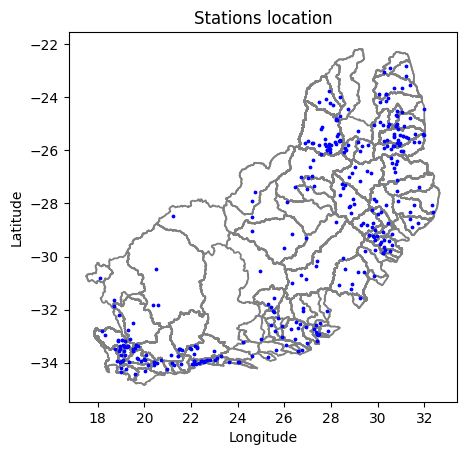

In [16]:
import matplotlib.pyplot as plt

# Plot the polygons
stations_by_polygon.plot(ax=plt.gca(), facecolor='none', edgecolor='grey', linewidth=1.25, label='Polygons')

# Create a scatter plot of the points
plt.scatter(stations_by_polygon['LONGITUDE'], stations_by_polygon['LATITUDE'], color='blue', label='Stations', s=3)

# Set figure title and labels
plt.title('Stations location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Specify the output file path and name
fNout = f'{path_out}/{dir_out}/catchments_with_stations.shp'
# Export the GeoDataFrame to a shapefile
stations_by_polygon.to_file(fNout)

plt.savefig(f'{path_out}/{dir_out}/Qstations_location.png')